In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from data import data_preprocess
from evaluation import metrics
from model import end2end

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('kin8nm')

In [3]:
end2end_model = end2end.train_model(x_train, y_train, n_epoch = 500, hidden_layers = [100, 100, 100], learning_rate = 0.001, exp_decay = .995, calibration_threshold = .03)

initial loss:  0.5082708597183228
251 0.041706396130072536 tensor(-3.4869, grad_fn=<MeanBackward0>) tensor(0.0430, grad_fn=<SumBackward1>)
252 0.20730177371674288 tensor(-3.4437, grad_fn=<MeanBackward0>) tensor(0.0587, grad_fn=<SumBackward1>)
253 0.0790312281644719 tensor(-3.4260, grad_fn=<MeanBackward0>) tensor(0.0467, grad_fn=<SumBackward1>)
254 0.30628817522171464 tensor(-3.3500, grad_fn=<MeanBackward0>) tensor(0.0682, grad_fn=<SumBackward1>)
255 0.10784694974469225 tensor(-3.3888, grad_fn=<MeanBackward0>) tensor(0.0493, grad_fn=<SumBackward1>)
256 0.3162723730180059 tensor(-3.3393, grad_fn=<MeanBackward0>) tensor(0.0692, grad_fn=<SumBackward1>)
257 0.08231214727223862 tensor(-3.4344, grad_fn=<MeanBackward0>) tensor(0.0470, grad_fn=<SumBackward1>)
258 0.2239145122278958 tensor(-3.4332, grad_fn=<MeanBackward0>) tensor(0.0602, grad_fn=<SumBackward1>)
259 0.04899494759473257 tensor(-3.4970, grad_fn=<MeanBackward0>) tensor(0.0438, grad_fn=<SumBackward1>)
260 0.14787538296156952 tensor(-

370 0.044697393173878025 tensor(-3.8487, grad_fn=<MeanBackward0>) tensor(0.0433, grad_fn=<SumBackward1>)
372 0.043792528890083324 tensor(-3.8527, grad_fn=<MeanBackward0>) tensor(0.0432, grad_fn=<SumBackward1>)
374 0.043093603869927465 tensor(-3.8562, grad_fn=<MeanBackward0>) tensor(0.0431, grad_fn=<SumBackward1>)
376 0.04301139478634778 tensor(-3.8595, grad_fn=<MeanBackward0>) tensor(0.0431, grad_fn=<SumBackward1>)
378 0.04306729373824243 tensor(-3.8626, grad_fn=<MeanBackward0>) tensor(0.0431, grad_fn=<SumBackward1>)
380 0.04316288632088151 tensor(-3.8657, grad_fn=<MeanBackward0>) tensor(0.0431, grad_fn=<SumBackward1>)
382 0.043065116904058086 tensor(-3.8689, grad_fn=<MeanBackward0>) tensor(0.0431, grad_fn=<SumBackward1>)
384 0.04275802203708683 tensor(-3.8719, grad_fn=<MeanBackward0>) tensor(0.0431, grad_fn=<SumBackward1>)
386 0.04217127116366568 tensor(-3.8752, grad_fn=<MeanBackward0>) tensor(0.0431, grad_fn=<SumBackward1>)
388 0.04162781510346685 tensor(-3.8787, grad_fn=<MeanBackwar

Deep ensemble test MAPE:  0.13007475
Deep ensemble test RMSE:  0.09039107


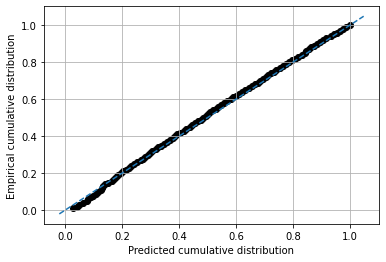

Deep ensemble test calibration error when step size is 0.001:  0.1996303335295346
Deep ensemble test calibration error when step size is 0.01:  0.020159626584384135
Deep ensemble test calibration error when step size is 0.1:  0.0017980725992490735


In [4]:
mean_pred, var_pred = end2end_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()

print('End2end test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('End2end test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('End2end test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('End2end test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('End2end test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))